
# Regressão Linear — Capítulo 2 (Notas de Aula)  
Implementação prática em Jupyter Notebook

**Objetivo:** Este notebook implementa e demonstra, no *dataset* anexado, os tópicos do Capítulo 2 das notas de aula:
1. **Regressão linear analítica** (Seção 2.2.1) — solução pela equação normal.  
2. **Regressão linear iterativa com BGD** (Seção 2.2.2) — *Batch Gradient Descent*.  
3. **Regressão linear iterativa com SGD** — *Stochastic Gradient Descent*.  
4. **Avaliação da qualidade da regressão** (Seção 2.3) — métricas (MSE, RMSE, MAE, R²), análise de resíduos e gráficos.

> Obs.: Para a etapa com gradiente, padronizamos as *features* (média 0, desvio-padrão 1) para melhorar a estabilidade numérica e a convergência.


## 1) Carregando o Dataset

In [3]:
from pathlib import Path
import pandas as pd

# A função pd.read_csv() lê o arquivo e o carrega em um DataFrame do pandas.
DATA_PATH = Path.cwd().joinpath(Path("Exercicio01/dataset/data_0460_5832.csv"))
df = pd.read_csv(DATA_PATH)

# O comando .head() mostra as 5 primeiras linhas do DataFrame.
print("Primeiras 5 linhas do dataset:")
print(df.head())

# O comando .info() mostra um resumo técnico, incluindo os tipos de cada coluna.
print('\nInformações do DataFrame:')
df.info()

Primeiras 5 linhas do dataset:
      Sex  Age  Height  Weight  Shoe number
0  Female   53     154      59           36
1    Male   23     170      56           40
2  Female   23     167      63           37
3    Male   21     178      78           40
4  Female   25     153      58           36

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sex          257 non-null    object
 1   Age          257 non-null    int64 
 2   Height       257 non-null    int64 
 3   Weight       257 non-null    int64 
 4   Shoe number  257 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.2+ KB


## 2) Tratamento dos dados

Antes de treinar nosso modelo, precisamos preparar os dados. Isso envolve:

1.  **Lidar com variáveis categóricas**: A coluna `Sex` é categórica ('Male'/'Female'). Os modelos de regressão linear requerem entradas numéricas. Usaremos uma técnica chamada *one-hot encoding* para converter essa coluna em colunas numéricas (0s e 1s).
2.  **Definir Features (X) e Target (y)**: Separaremos nosso conjunto de dados em:
    * `X`: a matriz de features (as variáveis que usaremos para fazer a previsão).
    * `y`: o vetor alvo (a variável que queremos prever, neste caso, `Weight`).

In [4]:
import numpy as np

# Copiar o df original para não sobrescrever
df_encoded = df.copy()

# Identificar colunas categóricas que só têm dois valores
for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
    valores = df_encoded[col].dropna().unique()
    if len(valores) == 2:
        # mapear automaticamente para 0/1
        mapping = {valores[0]: 0, valores[1]: 1}
        df_encoded[col] = df_encoded[col].map(mapping)
        print(f"Coluna {col} mapeada para {mapping}")
    else:
        df_encoded.drop(columns=[col], inplace=True)
# remove colunas constantes
num_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if df_encoded[c].nunique(dropna=True) > 1]


Coluna Sex mapeada para {'Female': 0, 'Male': 1}


## 3) Setup programação concorrente

Evitar oversubscription e definir o jumero de jobs. Dentro de cada processo vamos zerar os threads de BLAS para 1, para que o NumPy/MKL não abra várias threads por processo e no cenário de paralelismo perca desempenho.

In [5]:
import os, math

# Evita cada processo abrir vários threads de BLAS
os.environ["OMP_NUM_THREADS"]      = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"]      = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"]  = "1"

def get_n_jobs(default=8):
    """Usa SLURM_CPUS_PER_TASK se existir; caso contrário, usa até default/cpus."""
    v = os.getenv("SLURM_CPUS_PER_TASK")
    if v and v.isdigit():
        return int(v)
    try:
        return min(default, os.cpu_count() or default)
    except Exception:
        return default

## 4) Regressão Linear Iterativa — **Batch Gradient Descent** (Seção 2.2.2)

Minimizamos a perda de erro quadrático médio (MSE):
$$ L(\mathbf{w}) = \frac{1}{2N}\sum_{n=1}^{N} (\hat{y}^{(n)} - y^{(n)})^2, \quad \hat{y} = \mathbf{X}\mathbf{w} $$

**Gradiente:**
$$ \nabla L(\mathbf{w}) = \frac{1}{N}\, \mathbf{X}^\top(\mathbf{X}\mathbf{w} - \mathbf{y}) $$

**Atualização (BGD):**
$$ \mathbf{w} \leftarrow \mathbf{w} - \eta\, \nabla L(\mathbf{w}) $$

Para boa convergência, padronizamos as *features* (mantendo o intercepto separado).

In [ ]:
import time, math
import numpy as np
import torch

def fit_line_bgd_with_history(
    x_np, y_np, *, lr=1e-2, epochs=5000, tol=1e-8,
    normalize=True, seed=0
):
    """
    Regressão linear 1D: y ~ w0 + w1 * x
    Retorna: dict com w0, w1 (na escala original), métricas e history (lista de losses por época)
    """
    rng = np.random.default_rng(seed)

    # -> tensores coluna (N,1)
    x = torch.tensor(np.asarray(x_np).reshape(-1,1), dtype=torch.float32)
    y = torch.tensor(np.asarray(y_np).reshape(-1,1), dtype=torch.float32)
    N = x.shape[0]

    # normalização opcional (x normalizado; y fica na escala original)
    if normalize:
        mu_x = x.mean(0)
        std_x = x.std(0, unbiased=False).clamp_min(1e-12)
        xz   = (x - mu_x) / std_x
    else:
        mu_x, std_x = torch.tensor(0.), torch.tensor(1.)
        xz = x

    # modelo na escala normalizada: y ≈ b + a * xz
    a = torch.zeros((), dtype=torch.float32, requires_grad=True)
    b = torch.zeros((), dtype=torch.float32, requires_grad=True)

    opt = torch.optim.SGD([a, b], lr=lr)
    loss_hist = []
    grad_norm = float("nan")

    t0 = time.perf_counter()
    for it in range(epochs):
        opt.zero_grad()
        yhat = b + a * xz
        loss = torch.mean((yhat - y) ** 2)         # MSE
        loss.backward()

        # norma do gradiente para critério de parada
        gn_a = float(a.grad.detach().abs())
        gn_b = float(b.grad.detach().abs())
        grad_norm = math.hypot(gn_a, gn_b)

        opt.step()
        loss_hist.append(float(loss.detach()))

        if grad_norm < tol:    # convergiu
            break
    wall_s = time.perf_counter() - t0

    # volta pesos para a escala ORIGINAL: y ≈ w0 + w1 * x
    w1 = (a / std_x).detach()
    w0 = (b - a * mu_x / std_x).detach()

    with torch.no_grad():
        yhat_orig = w0 + w1 * x
        sse = torch.sum((y - yhat_orig) ** 2)
        sst = torch.sum((y - y.mean()) ** 2)
        ssr = torch.sum((yhat_orig - y.mean()) ** 2)
        r2  = 1.0 - sse / (sst + 1e-12)
        mse = torch.mean((y - yhat_orig) ** 2)

    return {
        "w0": float(w0.numpy()),
        "w1": float(w1.numpy()),
        "R2": float(r2.numpy()),
        "MSE": float(mse.numpy()),
        "SSE": float(sse.numpy()),
        "SSR": float(ssr.numpy()),
        "SST": float(sst.numpy()),
        "iters": it+1,
        "grad_norm": grad_norm,
        "wall_s": wall_s,
        "history": loss_hist,
    }

## 5) Execução da regressão utilizando paralelização

In [8]:
import pandas as pd

def run_pair_bgd(df_encoded: pd.DataFrame, x_col: str, y_col: str,
                 lr=1e-2, epochs=8000, tol=1e-7, normalize=True, seed=0):
    """Roda BGD para um par (x,y) do df_encoded e devolve um dict com o resultado."""
    pair = df_encoded[[x_col, y_col]].dropna()
    if pair[x_col].nunique() < 2 or pair[y_col].nunique() < 2:
        return None  # ignora combinações degeneradas

    x_np = pair[x_col].to_numpy()
    y_np = pair[y_col].to_numpy()

    out = fit_line_bgd_with_history(x_np, y_np, lr=lr, epochs=epochs, tol=tol,
                       normalize=normalize, seed=seed)

    out.update({
        "kind": "BGD",
        "x": x_col, "y": y_col,
        "N": int(len(pair))
    })
    return out

In [13]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import itertools

# ---- ajuste os hiperparâmetros aqui ----
LR       = 1e-2
EPOCHS   = 200000
TOL      = 1e-4
NORMAL   = True
SEED     = 0
N_JOBS   = get_n_jobs(default=8)   # usa SLURM_CPUS_PER_TASK se existir

cols = df_encoded.columns.tolist()
pairs = list(itertools.permutations(cols, 2))  # assimétrico

def _runner(p):
    x_col, y_col = p
    return run_pair_bgd(df_encoded, x_col, y_col,
                        lr=LR, epochs=EPOCHS, tol=TOL,
                        normalize=NORMAL, seed=SEED)

print(f"CPUs (n_jobs) = {N_JOBS}  |  nº de pares = {len(pairs)}")

results = Parallel(n_jobs=N_JOBS, backend="loky", verbose=0)(
    delayed(_runner)(p) for p in tqdm(pairs)
)
results = [r for r in results if r is not None]

CPUs (n_jobs) = 16  |  nº de pares = 20


100%|██████████| 20/20 [00:00<00:00, 77.83it/s]


## 6) Análise da qualidade da regressão (Seção 2.3)

Métricas principais:
- **MSE**, **RMSE**, **MAE**
- **Coeficiente de determinação (R²)**: $$ R^2 = 1 - \frac{\sum (y - \hat{y})^2}{\sum (y - \bar{y})^2} $$

Análises gráficas:
- **Resíduos vs. predições** (busca padrão sem estrutura — homocedasticidade)
- **Histograma de resíduos** (aprox. simétrico, média ~ 0)


In [10]:
results_bgd = pd.DataFrame(results).sort_values(["x","y"]).reset_index(drop=True)
display(results_bgd)
print("Total linhas:", len(results_bgd))

,w0,w1,yhat,SSE,SST,SSR,R2,MSE,iters,grad_norm,wall_s,history,N,mu_x,std_x,kind,x,y
0,169.239097,0.033947,"[171.03827, 170.01987, 170.01987, 169.95198, 1...",53565.804688,53618.070312,52.265652,0.000975,208.427256,200000,0.000737,48.130544,"[29178.7890625, 28031.564453125, 26929.7675781...",257,28.478600,13.284398,BGD,Age,Height
1,0.899029,-0.007523,"[0.5002971, 0.72599417, 0.72599417, 0.74104065...",52.903461,55.470818,2.567002,0.046283,0.205850,474,0.000098,0.209521,"[0.6848248839378357, 0.6658574938774109, 0.647...",257,28.478600,13.284398,BGD,Age,Sex
2,39.727516,-0.008197,"[39.29306, 39.53898, 39.53898, 39.555374, 39.5...",2317.193359,2320.241211,3.047613,0.001314,9.016317,200000,0.000190,47.504055,"[1568.817138671875, 1507.0489501953125, 1447.7...",257,28.478600,13.284398,BGD,Age,Shoe number
3,63.940124,0.226034,"[75.91991, 69.13889, 69.13889, 68.68683, 69.59...",64413.187500,66730.390625,2317.196289,0.034725,250.634971,200000,0.000378,47.546854,"[5212.63427734375, 5016.138671875, 4827.425292...",257,28.478600,13.284398,BGD,Age,Weight
4,23.591115,0.028715,"[28.013195, 28.472631, 28.386486, 28.702349, 2...",45309.921875,45354.132812,44.210220,0.000975,176.303198,653,0.000098,0.236559,"[987.505859375, 955.3821411132812, 924.5307006...",257,170.206223,14.444052,BGD,Height,Age
5,-2.002836,0.015790,"[0.42887712, 0.68152285, 0.6341517, 0.8078456,...",42.100174,55.470818,13.368865,0.241039,0.163814,476,0.000098,0.173640,"[0.6848248839378357, 0.664192795753479, 0.6443...",257,170.206223,14.444052,BGD,Height,Sex
6,9.639330,0.175403,"[36.651443, 39.457893, 38.931686, 40.861122, 3...",670.602600,2320.241211,1649.631104,0.710977,2.609349,200000,0.000190,48.764085,"[1568.817138671875, 1506.7952880859375, 1447.2...",257,170.206223,14.444052,BGD,Height,Shoe number
7,-38.473298,0.639522,"[60.013023, 70.24536, 68.3268, 75.361534, 59.3...",44801.140625,66730.390625,21929.134766,0.328625,174.323504,200000,0.000376,59.723791,"[5212.63427734375, 5013.11669921875, 4821.5009...",257,170.206223,14.444052,BGD,Height,Weight
8,32.691302,-6.151573,"[32.691303, 26.53973, 32.691303, 26.53973, 32....",43255.007812,45354.132812,2099.118652,0.046283,168.307423,654,0.000094,0.284874,"[987.505859375, 955.0655517578125, 923.9099121...",257,0.684825,0.464586,BGD,Sex,Age
9,159.752730,15.263940,"[159.75273, 175.01668, 159.75273, 175.01668, 1...",40694.007812,53618.070312,12924.038086,0.241039,158.342443,200000,0.000727,48.883638,"[29178.7890625, 28029.580078125, 26925.8789062...",257,0.684825,0.464586,BGD,Sex,Height


Total linhas: 20


## 7) Análise do aprendizado

1) Curva da Loss
2) Variação da Loss por epoca


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histories(results_df, n=5, smooth_k=5, max_epochs=None):
    """
    Plota curvas de loss para até n pares armazenados em results_df.
    
    results_df: DataFrame com colunas ["x","y","history",...]
    n: número máximo de pares a plotar
    smooth_k: janela da média móvel para suavizar a curva (se >1)
    max_epochs: número máximo de épocas a exibir (None = usa tudo)
    """
    def moving_average(arr, k):
        if k <= 1 or len(arr) < k:
            return np.array(arr, dtype=float)
        return np.convolve(arr, np.ones(k)/k, mode="valid")

    for i, row in results_df.iterrows():
        if i >= n:
            break
        hist = row["history"]
        if max_epochs is not None:
            hist = hist[:max_epochs]

        x_label = row["x"]
        y_label = row["y"]

        plt.figure(figsize=(10,4))

        # curva bruta
        plt.subplot(1,2,1)
        plt.plot(hist, color="tab:blue")
        plt.title(f"Loss (MSE) - {x_label}→{y_label}")
        plt.xlabel("Época")
        plt.ylabel("Loss")
        plt.grid(alpha=0.3)

        # curva suavizada
        plt.subplot(1,2,2)
        plt.plot(moving_average(hist, smooth_k), color="tab:orange")
        plt.title(f"Loss suavizada ({x_label}→{y_label})")
        plt.xlabel("Época")
        plt.ylabel("Loss (média móvel)")
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

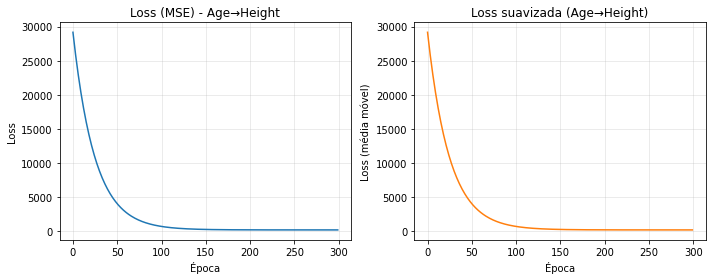

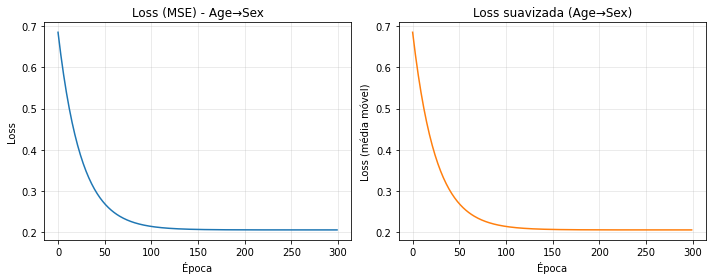

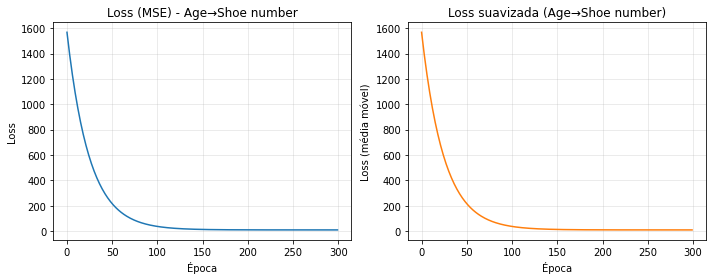

In [49]:
# plota só as max_epochs primeiras épocas de até n pares
plot_histories(results_bgd, n=3, smooth_k=0, max_epochs=300)

## 8) Salvando os resultados

In [30]:
from pathlib import Path

# Caminho da pasta onde vamos salvar
DATA_PATH = Path.cwd().joinpath("Exercicio01/tabela")
DATA_PATH.mkdir(parents=True, exist_ok=True)  # cria se não existir

# Ordem desejada das colunas
col_order = [
    "kind", "x", "y", "w0", "w1",
    "SSE", "SSR", "SST", "R2", "MSE",
    "iters", "grad_norm", "wall_s", "peak_mb", "N"
]

# Reorganiza (somente as que realmente existem no DataFrame)
cols_present = [c for c in col_order if c in results_bgd.columns]
results_bgd = results_bgd[cols_present]

# Salva
results_file = DATA_PATH / "results_BGD.csv"
results_bgd.to_csv(results_file, index=False)

print(f"Arquivo salvo em: {results_file}")
print("Colunas na ordem:", results_bgd.columns.tolist())

Arquivo salvo em: /home/nara/MAC5921-Deep-Learning/Exercicio01/tabela/results_BGD.csv
Colunas na ordem: ['kind', 'x', 'y', 'w0', 'w1', 'SSE', 'SSR', 'SST', 'R2', 'MSE', 'iters', 'grad_norm', 'wall_s', 'N']
